# Results (tables, figs)

In [1]:
import torch.nn as nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision, math, os, torch
import lightning as pl

name = 'PVAE_minimal' #change to your run name
data_dir = "./Data/Datasets/" #change to your data directory
project_name = "PVAE" #change to your wandb project name
root_dir = "data"
bsize = 256
train_device = "0"
device = train_device + "," #lightning device formatting
checkpoint_dir = os.path.join(root_dir, name)
os.makedirs(checkpoint_dir, exist_ok=True)

In [2]:
ds_train = datasets.MNIST(data_dir, train=True, download=True).data
ds_test = datasets.MNIST(data_dir, train=False, download=True).data
ds_train = (ds_train.float().reshape(-1, 784)/255)
ds_test = (ds_test.float().reshape(-1, 784)/255)
ds_train = torch.utils.data.TensorDataset(ds_train)
ds_test = torch.utils.data.TensorDataset(ds_test)

# Add num_workers for better performance
train_dl = DataLoader(ds_train, batch_size=bsize, shuffle=True, num_workers=4)
val_dl = DataLoader(ds_test, batch_size=bsize, shuffle=False, num_workers=4)

In [3]:
class Poisson:
    def __init__(self, log_rate, t=0.0):
        self.log_rate = log_rate
        self.rate = torch.exp(
            self.log_rate.clamp(None, 5)
        ) + 1e-6
        self.n_trials = int(math.ceil(max(self.rate.max().item(),1)*5)) # a large enough number of trials to sample from
        self.t = t
    def rsample(self, hard: bool = False, return_indicator=False):
        x = torch.distributions.Exponential(self.rate).rsample((self.n_trials,))  # inter-event times
        times = torch.cumsum(x, dim=0)  # arrival times of events
        indicator = times < 1.0 # did events arrive before the end of the time interval
        if not (hard or self.t == 0): # soften the indicator function
            indicator = torch.sigmoid((1.0 - times) / self.t)
        if return_indicator:
          return indicator.sum(0).float(), indicator, times
        else:
          return indicator.sum(0).float()
    def kl(self, prior, du):
        #"prior" argument referes to log rate of prior
        #equation is r * (1 - dr + dr * log(dr))
        r = torch.exp(prior.clamp(None, 5)) + 1e-6
        rdr = self.rate #final rate is rdr
        logdr = du #log of the modulation of prior rate
        return r-rdr+rdr*logdr

In [4]:
class PVAE(nn.Module):
    def __init__(self):
        super(PVAE, self).__init__()
        self.encode = nn.Sequential(
            nn.Linear(784, 128),
        )
        self.decode = nn.Sequential(
            nn.Linear(128, 784),
            nn.Sigmoid(),
        )
        self.prior = nn.Parameter(torch.zeros((1, 128)))
        self.t = 1.0 #temperature
    def forward(self, x):
        validation = not torch.is_grad_enabled()
        du = self.encode(x).clamp(None, 5)
        dist = Poisson((du + self.prior.clamp(None, 5)).clamp(None, 5), self.t)
        z = dist.rsample(hard=validation)
        y = self.decode(z)
        return dist, du, z, y

In [5]:
class PL_PVAE(pl.LightningModule):
    def __init__(self):
        super(PL_PVAE, self).__init__()
        self.model = PVAE()
        self.opt = torch.optim.Adam
        self.opt_params = {
            'lr': 1e-3,
        }
        self.beta = 0.0
    def forward(self, x):
        return self.model(x[0].flatten(1))
    def training_step(self, batch, batch_idx):
        epoch = self.current_epoch + batch_idx/len(train_dl)
        self.beta = min(5.0, 5*epoch/250)
        self.model.t = max((1.0 - 0.95*epoch/250), 0.05)
        self.log('beta', self.beta)
        self.log('t', self.model.t)

        dist, du, z, y = self(batch)
        kl = dist.kl(self.model.prior, du).mean()
        mse = ((y - batch[0])**2).sum(-1).mean()
        loss = self.beta*kl + mse
        self.log('train_loss', loss.item(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_elbo', (kl + mse).item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss
    @torch.no_grad()
    def validation_step(self, batch, batch_idx):
        dist, du, z, y = self(batch)
        kl = dist.kl(self.model.prior, du).mean()
        mse = ((y - batch[0])**2).sum(-1).mean()
        loss = self.beta*kl + mse

        self.log('val_mse', mse.item(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_kl', kl.item(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_elbo', (kl + mse).item(), on_step=True, on_epoch=True, prog_bar=True)
        self.log('l0_sparsity', (z == 0).float().mean().item(), on_step=True, on_epoch=True, prog_bar=True)
        return loss
    def configure_optimizers(self):
        return self.opt(self.parameters(), **self.opt_params)

In [6]:
model = PL_PVAE()
trainer_args = {
    "callbacks": [pl.pytorch.callbacks.ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_elbo', save_top_k=1, mode='min', verbose=True)],
    "accelerator": "cpu" if device == 'cpu' else "gpu",
    "gradient_clip_val": 1.0,
}
#trainer_args["logger"].watch(model, log="all")
if device != 'cpu':
    trainer_args["devices"] = device
trainer = pl.Trainer(**trainer_args, default_root_dir=checkpoint_dir, max_epochs=55, num_sanity_val_steps=0)
trainer.fit(model, val_dataloaders=val_dl, train_dataloaders=train_dl)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/hayden/miniconda3/envs/cajal/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal exists and is not empty.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | PVAE | 201 K  | train
---------------------------------------
201 K     Trainable params
0         Non-trainable params
201 K     Total params
0.807     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/Users/hayden/miniconda3/envs/cajal/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal exists and is not empty

Epoch 0: 100%|██████████| 235/235 [00:09<00:00, 23.75it/s, v_num=3, train_loss_step=13.10, train_elbo_step=19.20, val_mse_step=12.40, val_kl_step=12.00, val_elbo_step=24.30, l0_sparsity_step=0.0483, val_mse_epoch=15.40, val_kl_epoch=6.310, val_elbo_epoch=21.70, l0_sparsity_epoch=0.0906, train_loss_epoch=27.70, train_elbo_epoch=31.00]

Epoch 0, global step 235: 'val_elbo' reached 21.72278 (best 21.72278), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=0-step=235.ckpt' as top 1


Epoch 1: 100%|██████████| 235/235 [00:09<00:00, 24.44it/s, v_num=3, train_loss_step=9.330, train_elbo_step=15.40, val_mse_step=8.800, val_kl_step=11.90, val_elbo_step=20.70, l0_sparsity_step=0.0474, val_mse_epoch=12.40, val_kl_epoch=6.550, val_elbo_epoch=19.00, l0_sparsity_epoch=0.073, train_loss_epoch=10.20, train_elbo_epoch=16.30] 

Epoch 1, global step 470: 'val_elbo' reached 18.98311 (best 18.98311), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=1-step=470.ckpt' as top 1


Epoch 2: 100%|██████████| 235/235 [00:08<00:00, 27.76it/s, v_num=3, train_loss_step=8.440, train_elbo_step=14.30, val_mse_step=8.740, val_kl_step=9.920, val_elbo_step=18.70, l0_sparsity_step=0.0483, val_mse_epoch=11.40, val_kl_epoch=5.750, val_elbo_epoch=17.20, l0_sparsity_epoch=0.080, train_loss_epoch=8.620, train_elbo_epoch=14.10]

Epoch 2, global step 705: 'val_elbo' reached 17.18991 (best 17.18991), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=2-step=705.ckpt' as top 1


Epoch 3: 100%|██████████| 235/235 [00:07<00:00, 30.70it/s, v_num=3, train_loss_step=7.190, train_elbo_step=11.20, val_mse_step=8.710, val_kl_step=8.640, val_elbo_step=17.30, l0_sparsity_step=0.0581, val_mse_epoch=10.80, val_kl_epoch=5.230, val_elbo_epoch=16.00, l0_sparsity_epoch=0.087, train_loss_epoch=7.970, train_elbo_epoch=12.80]

Epoch 3, global step 940: 'val_elbo' reached 15.99110 (best 15.99110), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=3-step=940.ckpt' as top 1


Epoch 4: 100%|██████████| 235/235 [00:07<00:00, 32.50it/s, v_num=3, train_loss_step=7.440, train_elbo_step=11.40, val_mse_step=8.540, val_kl_step=7.130, val_elbo_step=15.70, l0_sparsity_step=0.0635, val_mse_epoch=10.40, val_kl_epoch=4.570, val_elbo_epoch=15.00, l0_sparsity_epoch=0.0955, train_loss_epoch=7.600, train_elbo_epoch=11.90]

Epoch 4, global step 1175: 'val_elbo' reached 14.96569 (best 14.96569), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=4-step=1175.ckpt' as top 1


Epoch 5: 100%|██████████| 235/235 [00:07<00:00, 33.26it/s, v_num=3, train_loss_step=6.800, train_elbo_step=10.60, val_mse_step=8.590, val_kl_step=6.350, val_elbo_step=14.90, l0_sparsity_step=0.084, val_mse_epoch=9.980, val_kl_epoch=4.240, val_elbo_epoch=14.20, l0_sparsity_epoch=0.102, train_loss_epoch=7.260, train_elbo_epoch=11.00]  

Epoch 5, global step 1410: 'val_elbo' reached 14.21240 (best 14.21240), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=5-step=1410.ckpt' as top 1


Epoch 6: 100%|██████████| 235/235 [00:06<00:00, 34.94it/s, v_num=3, train_loss_step=7.260, train_elbo_step=10.50, val_mse_step=8.140, val_kl_step=5.600, val_elbo_step=13.70, l0_sparsity_step=0.0854, val_mse_epoch=9.770, val_kl_epoch=3.850, val_elbo_epoch=13.60, l0_sparsity_epoch=0.111, train_loss_epoch=7.040, train_elbo_epoch=10.40]

Epoch 6, global step 1645: 'val_elbo' reached 13.62617 (best 13.62617), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=6-step=1645.ckpt' as top 1


Epoch 7: 100%|██████████| 235/235 [00:06<00:00, 34.60it/s, v_num=3, train_loss_step=6.460, train_elbo_step=9.260, val_mse_step=7.460, val_kl_step=4.920, val_elbo_step=12.40, l0_sparsity_step=0.0918, val_mse_epoch=9.600, val_kl_epoch=3.530, val_elbo_epoch=13.10, l0_sparsity_epoch=0.117, train_loss_epoch=6.860, train_elbo_epoch=9.880]

Epoch 7, global step 1880: 'val_elbo' reached 13.12939 (best 13.12939), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=7-step=1880.ckpt' as top 1


Epoch 8: 100%|██████████| 235/235 [00:06<00:00, 37.02it/s, v_num=3, train_loss_step=6.420, train_elbo_step=9.080, val_mse_step=7.680, val_kl_step=4.430, val_elbo_step=12.10, l0_sparsity_step=0.0972, val_mse_epoch=9.330, val_kl_epoch=3.280, val_elbo_epoch=12.60, l0_sparsity_epoch=0.124, train_loss_epoch=6.700, train_elbo_epoch=9.430]

Epoch 8, global step 2115: 'val_elbo' reached 12.61676 (best 12.61676), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=8-step=2115.ckpt' as top 1


Epoch 9: 100%|██████████| 235/235 [00:06<00:00, 37.27it/s, v_num=3, train_loss_step=6.120, train_elbo_step=8.550, val_mse_step=7.280, val_kl_step=3.960, val_elbo_step=11.20, l0_sparsity_step=0.118, val_mse_epoch=9.140, val_kl_epoch=3.020, val_elbo_epoch=12.20, l0_sparsity_epoch=0.131, train_loss_epoch=6.520, train_elbo_epoch=9.000] 

Epoch 9, global step 2350: 'val_elbo' reached 12.16520 (best 12.16520), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=9-step=2350.ckpt' as top 1


Epoch 10: 100%|██████████| 235/235 [00:06<00:00, 38.93it/s, v_num=3, train_loss_step=5.840, train_elbo_step=7.970, val_mse_step=7.600, val_kl_step=3.620, val_elbo_step=11.20, l0_sparsity_step=0.124, val_mse_epoch=8.970, val_kl_epoch=2.830, val_elbo_epoch=11.80, l0_sparsity_epoch=0.136, train_loss_epoch=6.350, train_elbo_epoch=8.610]

Epoch 10, global step 2585: 'val_elbo' reached 11.80588 (best 11.80588), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=10-step=2585.ckpt' as top 1


Epoch 11: 100%|██████████| 235/235 [00:06<00:00, 38.55it/s, v_num=3, train_loss_step=6.230, train_elbo_step=8.070, val_mse_step=7.960, val_kl_step=3.290, val_elbo_step=11.20, l0_sparsity_step=0.136, val_mse_epoch=8.780, val_kl_epoch=2.660, val_elbo_epoch=11.40, l0_sparsity_epoch=0.142, train_loss_epoch=6.250, train_elbo_epoch=8.320]

Epoch 11, global step 2820: 'val_elbo' reached 11.43799 (best 11.43799), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=11-step=2820.ckpt' as top 1


Epoch 12: 100%|██████████| 235/235 [00:06<00:00, 39.01it/s, v_num=3, train_loss_step=5.660, train_elbo_step=7.520, val_mse_step=7.390, val_kl_step=3.010, val_elbo_step=10.40, l0_sparsity_step=0.155, val_mse_epoch=8.700, val_kl_epoch=2.480, val_elbo_epoch=11.20, l0_sparsity_epoch=0.147, train_loss_epoch=6.150, train_elbo_epoch=8.050]

Epoch 12, global step 3055: 'val_elbo' reached 11.18255 (best 11.18255), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=12-step=3055.ckpt' as top 1


Epoch 13: 100%|██████████| 235/235 [00:05<00:00, 40.18it/s, v_num=3, train_loss_step=6.100, train_elbo_step=7.760, val_mse_step=7.290, val_kl_step=2.820, val_elbo_step=10.10, l0_sparsity_step=0.143, val_mse_epoch=8.540, val_kl_epoch=2.370, val_elbo_epoch=10.90, l0_sparsity_epoch=0.152, train_loss_epoch=6.020, train_elbo_epoch=7.770]

Epoch 13, global step 3290: 'val_elbo' reached 10.90771 (best 10.90771), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=13-step=3290.ckpt' as top 1


Epoch 14: 100%|██████████| 235/235 [00:05<00:00, 40.95it/s, v_num=3, train_loss_step=6.190, train_elbo_step=7.690, val_mse_step=8.140, val_kl_step=2.550, val_elbo_step=10.70, l0_sparsity_step=0.154, val_mse_epoch=8.460, val_kl_epoch=2.210, val_elbo_epoch=10.70, l0_sparsity_epoch=0.157, train_loss_epoch=5.930, train_elbo_epoch=7.550]

Epoch 14, global step 3525: 'val_elbo' reached 10.67074 (best 10.67074), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=14-step=3525.ckpt' as top 1


Epoch 15: 100%|██████████| 235/235 [00:05<00:00, 42.10it/s, v_num=3, train_loss_step=5.950, train_elbo_step=7.420, val_mse_step=7.310, val_kl_step=2.440, val_elbo_step=9.740, l0_sparsity_step=0.167, val_mse_epoch=8.230, val_kl_epoch=2.160, val_elbo_epoch=10.40, l0_sparsity_epoch=0.160, train_loss_epoch=5.850, train_elbo_epoch=7.350]

Epoch 15, global step 3760: 'val_elbo' reached 10.38937 (best 10.38937), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=15-step=3760.ckpt' as top 1


Epoch 16: 100%|██████████| 235/235 [00:05<00:00, 40.80it/s, v_num=3, train_loss_step=5.930, train_elbo_step=7.270, val_mse_step=7.940, val_kl_step=2.280, val_elbo_step=10.20, l0_sparsity_step=0.165, val_mse_epoch=8.160, val_kl_epoch=2.050, val_elbo_epoch=10.20, l0_sparsity_epoch=0.164, train_loss_epoch=5.780, train_elbo_epoch=7.180]

Epoch 16, global step 3995: 'val_elbo' reached 10.20975 (best 10.20975), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=16-step=3995.ckpt' as top 1


Epoch 17: 100%|██████████| 235/235 [00:05<00:00, 41.27it/s, v_num=3, train_loss_step=5.530, train_elbo_step=6.760, val_mse_step=7.740, val_kl_step=2.170, val_elbo_step=9.920, l0_sparsity_step=0.177, val_mse_epoch=8.020, val_kl_epoch=1.980, val_elbo_epoch=10.00, l0_sparsity_epoch=0.167, train_loss_epoch=5.700, train_elbo_epoch=7.010]

Epoch 17, global step 4230: 'val_elbo' reached 10.00320 (best 10.00320), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=17-step=4230.ckpt' as top 1


Epoch 18: 100%|██████████| 235/235 [00:05<00:00, 42.39it/s, v_num=3, train_loss_step=5.310, train_elbo_step=6.490, val_mse_step=7.430, val_kl_step=2.050, val_elbo_step=9.480, l0_sparsity_step=0.191, val_mse_epoch=8.010, val_kl_epoch=1.900, val_elbo_epoch=9.910, l0_sparsity_epoch=0.170, train_loss_epoch=5.620, train_elbo_epoch=6.840]

Epoch 18, global step 4465: 'val_elbo' reached 9.91257 (best 9.91257), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=18-step=4465.ckpt' as top 1


Epoch 19: 100%|██████████| 235/235 [00:05<00:00, 43.73it/s, v_num=3, train_loss_step=5.790, train_elbo_step=6.920, val_mse_step=7.440, val_kl_step=1.970, val_elbo_step=9.410, l0_sparsity_step=0.192, val_mse_epoch=7.830, val_kl_epoch=1.850, val_elbo_epoch=9.690, l0_sparsity_epoch=0.171, train_loss_epoch=5.560, train_elbo_epoch=6.700]

Epoch 19, global step 4700: 'val_elbo' reached 9.68509 (best 9.68509), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=19-step=4700.ckpt' as top 1


Epoch 20: 100%|██████████| 235/235 [00:05<00:00, 43.26it/s, v_num=3, train_loss_step=5.520, train_elbo_step=6.560, val_mse_step=7.610, val_kl_step=1.880, val_elbo_step=9.490, l0_sparsity_step=0.191, val_mse_epoch=7.810, val_kl_epoch=1.800, val_elbo_epoch=9.610, l0_sparsity_epoch=0.173, train_loss_epoch=5.500, train_elbo_epoch=6.570]

Epoch 20, global step 4935: 'val_elbo' reached 9.60708 (best 9.60708), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=20-step=4935.ckpt' as top 1


Epoch 21: 100%|██████████| 235/235 [00:05<00:00, 42.52it/s, v_num=3, train_loss_step=5.130, train_elbo_step=6.070, val_mse_step=7.620, val_kl_step=1.820, val_elbo_step=9.440, l0_sparsity_step=0.189, val_mse_epoch=7.730, val_kl_epoch=1.760, val_elbo_epoch=9.480, l0_sparsity_epoch=0.175, train_loss_epoch=5.450, train_elbo_epoch=6.470]

Epoch 21, global step 5170: 'val_elbo' reached 9.48286 (best 9.48286), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=21-step=5170.ckpt' as top 1


Epoch 22: 100%|██████████| 235/235 [00:05<00:00, 41.45it/s, v_num=3, train_loss_step=4.890, train_elbo_step=5.810, val_mse_step=7.970, val_kl_step=1.760, val_elbo_step=9.730, l0_sparsity_step=0.192, val_mse_epoch=7.630, val_kl_epoch=1.710, val_elbo_epoch=9.340, l0_sparsity_epoch=0.176, train_loss_epoch=5.410, train_elbo_epoch=6.370]

Epoch 22, global step 5405: 'val_elbo' reached 9.34148 (best 9.34148), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=22-step=5405.ckpt' as top 1


Epoch 23: 100%|██████████| 235/235 [00:05<00:00, 43.37it/s, v_num=3, train_loss_step=5.540, train_elbo_step=6.410, val_mse_step=7.640, val_kl_step=1.730, val_elbo_step=9.370, l0_sparsity_step=0.199, val_mse_epoch=7.570, val_kl_epoch=1.680, val_elbo_epoch=9.250, l0_sparsity_epoch=0.177, train_loss_epoch=5.390, train_elbo_epoch=6.290]

Epoch 23, global step 5640: 'val_elbo' reached 9.25132 (best 9.25132), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=23-step=5640.ckpt' as top 1


Epoch 24: 100%|██████████| 235/235 [00:05<00:00, 42.62it/s, v_num=3, train_loss_step=5.310, train_elbo_step=6.140, val_mse_step=7.410, val_kl_step=1.670, val_elbo_step=9.080, l0_sparsity_step=0.188, val_mse_epoch=7.480, val_kl_epoch=1.650, val_elbo_epoch=9.130, l0_sparsity_epoch=0.177, train_loss_epoch=5.360, train_elbo_epoch=6.210]

Epoch 24, global step 5875: 'val_elbo' reached 9.12971 (best 9.12971), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=24-step=5875.ckpt' as top 1


Epoch 25: 100%|██████████| 235/235 [00:05<00:00, 42.16it/s, v_num=3, train_loss_step=5.320, train_elbo_step=6.110, val_mse_step=7.300, val_kl_step=1.640, val_elbo_step=8.940, l0_sparsity_step=0.195, val_mse_epoch=7.400, val_kl_epoch=1.630, val_elbo_epoch=9.020, l0_sparsity_epoch=0.177, train_loss_epoch=5.330, train_elbo_epoch=6.140]

Epoch 25, global step 6110: 'val_elbo' reached 9.02458 (best 9.02458), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=25-step=6110.ckpt' as top 1


Epoch 26: 100%|██████████| 235/235 [00:05<00:00, 43.12it/s, v_num=3, train_loss_step=5.340, train_elbo_step=6.090, val_mse_step=7.600, val_kl_step=1.610, val_elbo_step=9.200, l0_sparsity_step=0.203, val_mse_epoch=7.410, val_kl_epoch=1.600, val_elbo_epoch=9.010, l0_sparsity_epoch=0.177, train_loss_epoch=5.310, train_elbo_epoch=6.070]

Epoch 26, global step 6345: 'val_elbo' reached 9.00833 (best 9.00833), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=26-step=6345.ckpt' as top 1


Epoch 27: 100%|██████████| 235/235 [00:05<00:00, 41.83it/s, v_num=3, train_loss_step=5.170, train_elbo_step=5.860, val_mse_step=7.320, val_kl_step=1.610, val_elbo_step=8.930, l0_sparsity_step=0.181, val_mse_epoch=7.340, val_kl_epoch=1.580, val_elbo_epoch=8.920, l0_sparsity_epoch=0.176, train_loss_epoch=5.290, train_elbo_epoch=6.010]

Epoch 27, global step 6580: 'val_elbo' reached 8.92412 (best 8.92412), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=27-step=6580.ckpt' as top 1


Epoch 28: 100%|██████████| 235/235 [00:05<00:00, 42.60it/s, v_num=3, train_loss_step=5.240, train_elbo_step=5.900, val_mse_step=6.900, val_kl_step=1.580, val_elbo_step=8.480, l0_sparsity_step=0.196, val_mse_epoch=7.280, val_kl_epoch=1.570, val_elbo_epoch=8.850, l0_sparsity_epoch=0.175, train_loss_epoch=5.280, train_elbo_epoch=5.960]

Epoch 28, global step 6815: 'val_elbo' reached 8.85157 (best 8.85157), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=28-step=6815.ckpt' as top 1


Epoch 29: 100%|██████████| 235/235 [00:05<00:00, 42.27it/s, v_num=3, train_loss_step=5.240, train_elbo_step=5.850, val_mse_step=7.070, val_kl_step=1.570, val_elbo_step=8.650, l0_sparsity_step=0.193, val_mse_epoch=7.240, val_kl_epoch=1.560, val_elbo_epoch=8.810, l0_sparsity_epoch=0.173, train_loss_epoch=5.270, train_elbo_epoch=5.920]

Epoch 29, global step 7050: 'val_elbo' reached 8.80919 (best 8.80919), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=29-step=7050.ckpt' as top 1


Epoch 30: 100%|██████████| 235/235 [00:05<00:00, 43.92it/s, v_num=3, train_loss_step=5.150, train_elbo_step=5.730, val_mse_step=7.330, val_kl_step=1.570, val_elbo_step=8.890, l0_sparsity_step=0.204, val_mse_epoch=7.240, val_kl_epoch=1.550, val_elbo_epoch=8.790, l0_sparsity_epoch=0.173, train_loss_epoch=5.270, train_elbo_epoch=5.880]

Epoch 30, global step 7285: 'val_elbo' reached 8.78579 (best 8.78579), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=30-step=7285.ckpt' as top 1


Epoch 31: 100%|██████████| 235/235 [00:05<00:00, 44.30it/s, v_num=3, train_loss_step=5.210, train_elbo_step=5.770, val_mse_step=7.500, val_kl_step=1.510, val_elbo_step=9.010, l0_sparsity_step=0.190, val_mse_epoch=7.180, val_kl_epoch=1.530, val_elbo_epoch=8.710, l0_sparsity_epoch=0.172, train_loss_epoch=5.260, train_elbo_epoch=5.840]

Epoch 31, global step 7520: 'val_elbo' reached 8.70921 (best 8.70921), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=31-step=7520.ckpt' as top 1


Epoch 32: 100%|██████████| 235/235 [00:05<00:00, 43.91it/s, v_num=3, train_loss_step=5.310, train_elbo_step=5.840, val_mse_step=7.420, val_kl_step=1.520, val_elbo_step=8.950, l0_sparsity_step=0.196, val_mse_epoch=7.150, val_kl_epoch=1.520, val_elbo_epoch=8.670, l0_sparsity_epoch=0.171, train_loss_epoch=5.270, train_elbo_epoch=5.800]

Epoch 32, global step 7755: 'val_elbo' reached 8.67204 (best 8.67204), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=32-step=7755.ckpt' as top 1


Epoch 33: 100%|██████████| 235/235 [00:05<00:00, 42.00it/s, v_num=3, train_loss_step=4.930, train_elbo_step=5.400, val_mse_step=7.230, val_kl_step=1.520, val_elbo_step=8.750, l0_sparsity_step=0.191, val_mse_epoch=7.160, val_kl_epoch=1.510, val_elbo_epoch=8.670, l0_sparsity_epoch=0.169, train_loss_epoch=5.260, train_elbo_epoch=5.760]

Epoch 33, global step 7990: 'val_elbo' reached 8.67060 (best 8.67060), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=33-step=7990.ckpt' as top 1


Epoch 34: 100%|██████████| 235/235 [00:05<00:00, 41.42it/s, v_num=3, train_loss_step=5.320, train_elbo_step=5.760, val_mse_step=7.360, val_kl_step=1.510, val_elbo_step=8.870, l0_sparsity_step=0.190, val_mse_epoch=7.120, val_kl_epoch=1.500, val_elbo_epoch=8.630, l0_sparsity_epoch=0.168, train_loss_epoch=5.260, train_elbo_epoch=5.730]

Epoch 34, global step 8225: 'val_elbo' reached 8.62719 (best 8.62719), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=34-step=8225.ckpt' as top 1


Epoch 35: 100%|██████████| 235/235 [00:05<00:00, 42.02it/s, v_num=3, train_loss_step=5.430, train_elbo_step=5.850, val_mse_step=7.440, val_kl_step=1.500, val_elbo_step=8.930, l0_sparsity_step=0.185, val_mse_epoch=7.100, val_kl_epoch=1.490, val_elbo_epoch=8.590, l0_sparsity_epoch=0.166, train_loss_epoch=5.270, train_elbo_epoch=5.710]

Epoch 35, global step 8460: 'val_elbo' reached 8.59034 (best 8.59034), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=35-step=8460.ckpt' as top 1


Epoch 36: 100%|██████████| 235/235 [00:05<00:00, 43.91it/s, v_num=3, train_loss_step=5.270, train_elbo_step=5.660, val_mse_step=6.680, val_kl_step=1.490, val_elbo_step=8.170, l0_sparsity_step=0.182, val_mse_epoch=7.090, val_kl_epoch=1.490, val_elbo_epoch=8.580, l0_sparsity_epoch=0.164, train_loss_epoch=5.270, train_elbo_epoch=5.680]

Epoch 36, global step 8695: 'val_elbo' reached 8.57732 (best 8.57732), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=36-step=8695.ckpt' as top 1


Epoch 37: 100%|██████████| 235/235 [00:05<00:00, 44.12it/s, v_num=3, train_loss_step=5.530, train_elbo_step=5.900, val_mse_step=6.810, val_kl_step=1.480, val_elbo_step=8.300, l0_sparsity_step=0.179, val_mse_epoch=7.050, val_kl_epoch=1.480, val_elbo_epoch=8.530, l0_sparsity_epoch=0.163, train_loss_epoch=5.280, train_elbo_epoch=5.650]

Epoch 37, global step 8930: 'val_elbo' reached 8.52987 (best 8.52987), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=37-step=8930.ckpt' as top 1


Epoch 38: 100%|██████████| 235/235 [00:05<00:00, 43.53it/s, v_num=3, train_loss_step=5.400, train_elbo_step=5.730, val_mse_step=7.350, val_kl_step=1.480, val_elbo_step=8.830, l0_sparsity_step=0.174, val_mse_epoch=6.990, val_kl_epoch=1.470, val_elbo_epoch=8.460, l0_sparsity_epoch=0.162, train_loss_epoch=5.300, train_elbo_epoch=5.640]

Epoch 38, global step 9165: 'val_elbo' reached 8.46103 (best 8.46103), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=38-step=9165.ckpt' as top 1


Epoch 39: 100%|██████████| 235/235 [00:05<00:00, 43.66it/s, v_num=3, train_loss_step=5.170, train_elbo_step=5.460, val_mse_step=7.100, val_kl_step=1.480, val_elbo_step=8.570, l0_sparsity_step=0.179, val_mse_epoch=6.990, val_kl_epoch=1.470, val_elbo_epoch=8.460, l0_sparsity_epoch=0.160, train_loss_epoch=5.310, train_elbo_epoch=5.620]

Epoch 39, global step 9400: 'val_elbo' reached 8.46010 (best 8.46010), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=39-step=9400.ckpt' as top 1


Epoch 40: 100%|██████████| 235/235 [00:05<00:00, 43.09it/s, v_num=3, train_loss_step=5.560, train_elbo_step=5.830, val_mse_step=6.700, val_kl_step=1.460, val_elbo_step=8.160, l0_sparsity_step=0.173, val_mse_epoch=7.060, val_kl_epoch=1.450, val_elbo_epoch=8.510, l0_sparsity_epoch=0.159, train_loss_epoch=5.320, train_elbo_epoch=5.600]

Epoch 40, global step 9635: 'val_elbo' was not in top 1


Epoch 41: 100%|██████████| 235/235 [00:05<00:00, 43.33it/s, v_num=3, train_loss_step=5.250, train_elbo_step=5.490, val_mse_step=7.000, val_kl_step=1.460, val_elbo_step=8.460, l0_sparsity_step=0.170, val_mse_epoch=7.020, val_kl_epoch=1.460, val_elbo_epoch=8.480, l0_sparsity_epoch=0.157, train_loss_epoch=5.340, train_elbo_epoch=5.590]

Epoch 41, global step 9870: 'val_elbo' was not in top 1


Epoch 42: 100%|██████████| 235/235 [00:05<00:00, 43.47it/s, v_num=3, train_loss_step=5.190, train_elbo_step=5.400, val_mse_step=7.140, val_kl_step=1.450, val_elbo_step=8.590, l0_sparsity_step=0.173, val_mse_epoch=7.000, val_kl_epoch=1.450, val_elbo_epoch=8.450, l0_sparsity_epoch=0.155, train_loss_epoch=5.360, train_elbo_epoch=5.580]

Epoch 42, global step 10105: 'val_elbo' reached 8.44884 (best 8.44884), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=42-step=10105.ckpt' as top 1


Epoch 43: 100%|██████████| 235/235 [00:05<00:00, 44.05it/s, v_num=3, train_loss_step=5.490, train_elbo_step=5.670, val_mse_step=6.810, val_kl_step=1.460, val_elbo_step=8.270, l0_sparsity_step=0.183, val_mse_epoch=7.010, val_kl_epoch=1.450, val_elbo_epoch=8.460, l0_sparsity_epoch=0.154, train_loss_epoch=5.380, train_elbo_epoch=5.570]

Epoch 43, global step 10340: 'val_elbo' was not in top 1


Epoch 44: 100%|██████████| 235/235 [00:05<00:00, 43.06it/s, v_num=3, train_loss_step=5.290, train_elbo_step=5.440, val_mse_step=6.770, val_kl_step=1.440, val_elbo_step=8.210, l0_sparsity_step=0.174, val_mse_epoch=6.990, val_kl_epoch=1.430, val_elbo_epoch=8.420, l0_sparsity_epoch=0.152, train_loss_epoch=5.390, train_elbo_epoch=5.550]

Epoch 44, global step 10575: 'val_elbo' reached 8.42049 (best 8.42049), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=44-step=10575.ckpt' as top 1


Epoch 45: 100%|██████████| 235/235 [00:05<00:00, 44.10it/s, v_num=3, train_loss_step=5.670, train_elbo_step=5.800, val_mse_step=7.280, val_kl_step=1.440, val_elbo_step=8.720, l0_sparsity_step=0.171, val_mse_epoch=7.010, val_kl_epoch=1.430, val_elbo_epoch=8.430, l0_sparsity_epoch=0.151, train_loss_epoch=5.410, train_elbo_epoch=5.530]

Epoch 45, global step 10810: 'val_elbo' was not in top 1


Epoch 46: 100%|██████████| 235/235 [00:05<00:00, 44.65it/s, v_num=3, train_loss_step=5.930, train_elbo_step=6.020, val_mse_step=7.060, val_kl_step=1.430, val_elbo_step=8.490, l0_sparsity_step=0.156, val_mse_epoch=7.010, val_kl_epoch=1.420, val_elbo_epoch=8.430, l0_sparsity_epoch=0.150, train_loss_epoch=5.430, train_elbo_epoch=5.530]

Epoch 46, global step 11045: 'val_elbo' was not in top 1


Epoch 47: 100%|██████████| 235/235 [00:05<00:00, 43.15it/s, v_num=3, train_loss_step=5.380, train_elbo_step=5.430, val_mse_step=6.210, val_kl_step=1.420, val_elbo_step=7.630, l0_sparsity_step=0.164, val_mse_epoch=6.990, val_kl_epoch=1.410, val_elbo_epoch=8.410, l0_sparsity_epoch=0.148, train_loss_epoch=5.450, train_elbo_epoch=5.520]

Epoch 47, global step 11280: 'val_elbo' reached 8.40714 (best 8.40714), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=47-step=11280.ckpt' as top 1


Epoch 48: 100%|██████████| 235/235 [00:05<00:00, 43.39it/s, v_num=3, train_loss_step=5.270, train_elbo_step=5.300, val_mse_step=7.480, val_kl_step=1.420, val_elbo_step=8.890, l0_sparsity_step=0.156, val_mse_epoch=6.990, val_kl_epoch=1.410, val_elbo_epoch=8.390, l0_sparsity_epoch=0.147, train_loss_epoch=5.460, train_elbo_epoch=5.510]

Epoch 48, global step 11515: 'val_elbo' reached 8.39071 (best 8.39071), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=48-step=11515.ckpt' as top 1


Epoch 49: 100%|██████████| 235/235 [00:05<00:00, 43.02it/s, v_num=3, train_loss_step=5.550, train_elbo_step=5.550, val_mse_step=6.900, val_kl_step=1.410, val_elbo_step=8.310, l0_sparsity_step=0.164, val_mse_epoch=7.000, val_kl_epoch=1.400, val_elbo_epoch=8.400, l0_sparsity_epoch=0.146, train_loss_epoch=5.480, train_elbo_epoch=5.500]

Epoch 49, global step 11750: 'val_elbo' was not in top 1


Epoch 50: 100%|██████████| 235/235 [00:05<00:00, 44.70it/s, v_num=3, train_loss_step=5.510, train_elbo_step=5.480, val_mse_step=7.620, val_kl_step=1.400, val_elbo_step=9.020, l0_sparsity_step=0.162, val_mse_epoch=6.990, val_kl_epoch=1.390, val_elbo_epoch=8.380, l0_sparsity_epoch=0.145, train_loss_epoch=5.510, train_elbo_epoch=5.490]

Epoch 50, global step 11985: 'val_elbo' reached 8.38067 (best 8.38067), saving model to '/Users/hayden/Desktop/code/cajal/project/PoissonVAE/data/PVAE_minimal/epoch=50-step=11985.ckpt' as top 1


Epoch 51: 100%|██████████| 235/235 [00:05<00:00, 44.48it/s, v_num=3, train_loss_step=5.740, train_elbo_step=5.680, val_mse_step=7.170, val_kl_step=1.400, val_elbo_step=8.570, l0_sparsity_step=0.165, val_mse_epoch=7.010, val_kl_epoch=1.390, val_elbo_epoch=8.400, l0_sparsity_epoch=0.143, train_loss_epoch=5.530, train_elbo_epoch=5.490]

Epoch 51, global step 12220: 'val_elbo' was not in top 1


Epoch 52: 100%|██████████| 235/235 [00:05<00:00, 43.57it/s, v_num=3, train_loss_step=5.500, train_elbo_step=5.420, val_mse_step=7.010, val_kl_step=1.400, val_elbo_step=8.410, l0_sparsity_step=0.152, val_mse_epoch=7.020, val_kl_epoch=1.380, val_elbo_epoch=8.400, l0_sparsity_epoch=0.142, train_loss_epoch=5.560, train_elbo_epoch=5.490]

Epoch 52, global step 12455: 'val_elbo' was not in top 1


Epoch 53: 100%|██████████| 235/235 [00:05<00:00, 42.81it/s, v_num=3, train_loss_step=5.270, train_elbo_step=5.170, val_mse_step=6.790, val_kl_step=1.390, val_elbo_step=8.190, l0_sparsity_step=0.153, val_mse_epoch=7.060, val_kl_epoch=1.370, val_elbo_epoch=8.440, l0_sparsity_epoch=0.143, train_loss_epoch=5.580, train_elbo_epoch=5.480]

Epoch 53, global step 12690: 'val_elbo' was not in top 1


Epoch 54: 100%|██████████| 235/235 [00:05<00:00, 44.21it/s, v_num=3, train_loss_step=5.440, train_elbo_step=5.300, val_mse_step=6.970, val_kl_step=1.380, val_elbo_step=8.350, l0_sparsity_step=0.155, val_mse_epoch=7.060, val_kl_epoch=1.370, val_elbo_epoch=8.430, l0_sparsity_epoch=0.140, train_loss_epoch=5.610, train_elbo_epoch=5.490]

Epoch 54, global step 12925: 'val_elbo' was not in top 1
`Trainer.fit` stopped: `max_epochs=55` reached.
`Trainer.fit` stopped: `max_epochs=55` reached.


Epoch 54: 100%|██████████| 235/235 [00:05<00:00, 44.19it/s, v_num=3, train_loss_step=5.440, train_elbo_step=5.300, val_mse_step=6.970, val_kl_step=1.380, val_elbo_step=8.350, l0_sparsity_step=0.155, val_mse_epoch=7.060, val_kl_epoch=1.370, val_elbo_epoch=8.430, l0_sparsity_epoch=0.140, train_loss_epoch=5.610, train_elbo_epoch=5.490]



In [6]:
# load network from .ckpt file

f = './epoch=50-step=11985.ckpt'
model = PL_PVAE.load_from_checkpoint(f)

In [7]:
model

PL_PVAE(
  (model): PVAE(
    (encode): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
    )
    (decode): Sequential(
      (0): Linear(in_features=128, out_features=784, bias=True)
      (1): Sigmoid()
    )
  )
)

torch.Size([784])


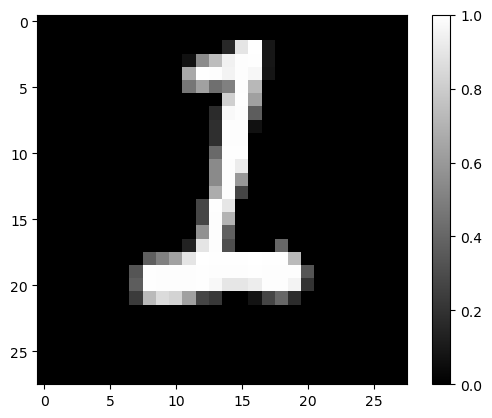

In [8]:
import matplotlib.pyplot as plt

batch = next(iter(train_dl))

img = batch[0][0]

print(img.shape)

plt.imshow(img.reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

Using device: mps


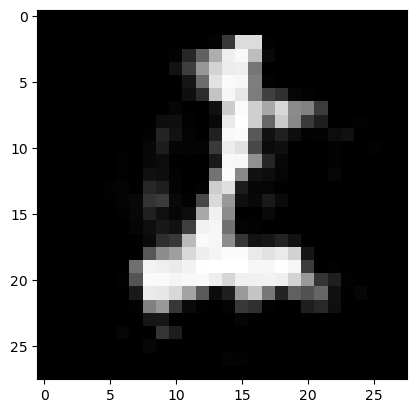

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move model and tensor to the same deviceprint(times.shape)
model = model.to(device)
x = img.to(device)

with torch.no_grad():
    dist, du, z, y = model.forward(x.unsqueeze(0).unsqueeze(0))


plt.imshow(y[0].cpu().numpy().reshape(28, 28), cmap='gray')

sample, indicator, times = dist.rsample(hard=True, return_indicator=True)



In [10]:
indicator.shape

torch.Size([82, 1, 128])

In [11]:
def spike_matrix_by_neuron(p: Poisson, n_steps: int):
    # 1) sample hard events
    _, indicator, times = p.rsample(hard=True, return_indicator=True)
    # times/indicator: (n_trials, n_neurons)

    n_neurons = times.shape[1]
    device    = times.device

    # 2) define time‐bin edges in [0,1]
    edges = torch.linspace(0.0, 1.0, n_steps + 1, device=device)

    # 3) flatten valid events
    #    trials: tensor of trial‐indices, neurons: matching neuron‐indices
    trials, neurons = torch.nonzero(indicator, as_tuple=True)
    t_flat = times[trials, neurons]                  # (N_events,)
    b_idx  = torch.bucketize(t_flat, edges) - 1       # bin ∈ [0..n_steps-1]

    # 4) (optional) prune any out‐of‐bounds (shouldn’t be needed if t_flat<1)
    mask = (b_idx >= 0) & (b_idx < n_steps)
    b_idx   = b_idx[mask]
    neurons = neurons[mask]

    # 5) accumulate into an (n_neurons × n_steps) int32 matrix
    counts = torch.zeros(n_neurons, n_steps,
                         dtype=torch.int32,
                         device=device)
    ones   = torch.ones_like(b_idx, dtype=torch.int32)

    # scatter: first dim is neuron‐index, second is time‐bin
    counts.index_put_(
        (neurons, b_idx),
        ones,
        accumulate=True
    )

    return counts    # shape: (128, 100) if n_neurons=128, n_steps=100

# OPTION B: use the new by‐neuron version directly
raster = spike_matrix_by_neuron(dist, n_steps=100)  # (128,100)

ValueError: too many values to unpack (expected 2)

torch.Size([88, 1, 128])
torch.Size([1, 128])
torch.Size([88, 1, 128])


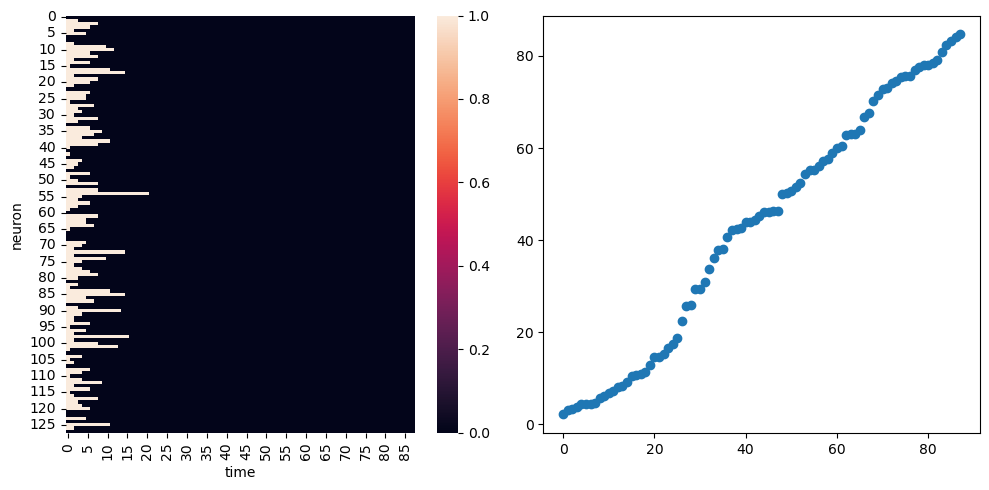

In [63]:
sample, indicator, times = dist.rsample(hard=True, return_indicator=True)


print(times.shape)
print(sample.shape)
print(indicator.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(indicator[:,0,:].long().cpu().numpy().T, ax=ax[0])
ax[0].set_xlabel('time')
ax[0].set_ylabel('neuron')

t = times[:,0,:][:,0].cpu().numpy()
ax[1].scatter(torch.arange(len(t)), t)

plt.tight_layout()
plt.show()

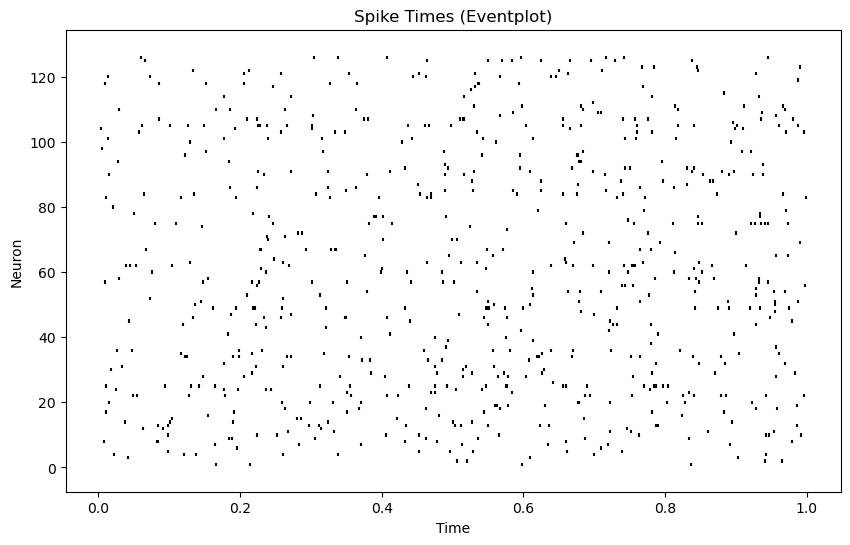

In [17]:
# Extract the spike times for each neuron
# We use the fact that indicator and times have shape (n_trials, 1, n_neurons)
indicator_np = indicator[:, 0, :].cpu().numpy()  # shape: (n_trials, n_neurons)
times_np = times[:, 0, :].cpu().numpy()          # shape: (n_trials, n_neurons)

# Create one spike train for each neuron based on the indicator mask
spike_trains = [times_np[:, i][indicator_np[:, i]] for i in range(indicator_np.shape[1])]

# Plot the spike times as an eventplot
plt.figure(figsize=(10, 6))
plt.eventplot(spike_trains, colors='black')
plt.xlabel("Time")
plt.ylabel("Neuron")
plt.title("Spike Times (Eventplot)")
plt.show()

In [59]:
batch = next(iter(train_dl))
img = batch[0][0]

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)
x = img.to(device)


with torch.no_grad():
    dist, du, z, y = model.forward(x.unsqueeze(0).unsqueeze(0))

Using device: mps


Cumulative matrix shape: torch.Size([128, 100])
Max cumulative spikes per neuron: tensor([15,  3,  5,  4,  6,  6, 11, 11, 14,  1,  8,  5,  0, 15,  7,  3,  2,  6,
        14,  6,  3,  7, 17,  9, 10, 10, 11,  1,  4,  7,  1,  3,  0,  1, 10,  6,
         1,  1,  4,  6,  7, 16,  0,  5,  3,  9,  5,  3,  0,  6,  4,  3,  0,  6,
         1,  4,  0, 13,  9,  1,  6,  1,  5,  3,  0,  6,  3,  8, 10, 11, 10, 11,
        10,  2,  7,  3,  1,  5,  0,  9,  2,  0,  2, 10, 11,  7,  3,  4, 20,  2,
         5,  3,  7,  2,  9,  0,  7,  5, 13,  1,  2,  1,  0,  0,  9,  8,  0,  7,
         6,  2,  1,  4,  8,  0,  3,  4,  0,  6,  6,  1,  0,  2, 13,  6,  4,  1,
         4,  1], device='mps:0')


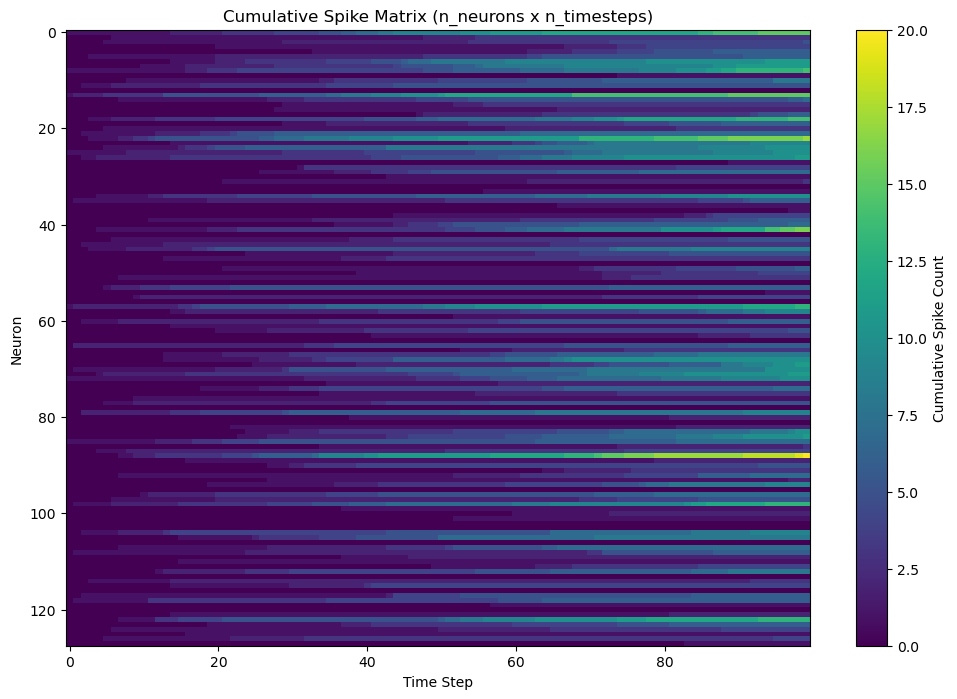

In [17]:
def cumulative_spike_matrix(indicator, times, n_steps=100):
    """
    Create a cumulative spike matrix (n_neurons x n_timesteps) showing 
    cumulative spike counts for each neuron up to each time step.
    
    Args:
        indicator: boolean tensor of shape (n_trials, batch_size, n_neurons)
        times: tensor of spike times of shape (n_trials, batch_size, n_neurons)  
        n_steps: number of time bins to discretize [0,1] interval
    
    Returns:
        cumulative_counts: tensor of shape (n_neurons, n_steps) with cumulative spike counts
    """
    # Squeeze out batch dimension (assuming batch_size=1)
    indicator_2d = indicator[:, 0, :]  # (n_trials, n_neurons)
    times_2d = times[:, 0, :]          # (n_trials, n_neurons)
    
    n_neurons = indicator_2d.shape[1]
    device = times.device
    
    # Create time bin edges
    edges = torch.linspace(0.0, 1.0, n_steps + 1, device=device)
    
    # Get valid spike times and corresponding neuron indices
    valid_mask = indicator_2d
    trials, neurons = torch.nonzero(valid_mask, as_tuple=True)
    valid_times = times_2d[trials, neurons]  # Flat array of all spike times
    
    # Find which time bin each spike falls into
    bin_indices = torch.bucketize(valid_times, edges) - 1
    # Clamp to valid range [0, n_steps-1]
    bin_indices = torch.clamp(bin_indices, 0, n_steps - 1)
    
    # Create a spike count matrix (n_neurons x n_steps)
    spike_counts = torch.zeros(n_neurons, n_steps, device=device, dtype=torch.int32)
    
    # Count spikes in each bin for each neuron
    for i in range(len(valid_times)):
        neuron_idx = neurons[i]
        time_bin = bin_indices[i]
        spike_counts[neuron_idx, time_bin] += 1
    
    # Convert to cumulative counts along time dimension
    cumulative_counts = torch.cumsum(spike_counts, dim=1)
    
    return cumulative_counts

# Example usage:
sample, indicator, times = dist.rsample(hard=True, return_indicator=True)
cumulative_matrix = cumulative_spike_matrix(indicator, times, n_steps=100)

print(f"Cumulative matrix shape: {cumulative_matrix.shape}")
print(f"Max cumulative spikes per neuron: {cumulative_matrix.max(dim=1)[0]}")

# Visualize the cumulative spike matrix
plt.figure(figsize=(12, 8))
plt.imshow(cumulative_matrix.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Cumulative Spike Count')
plt.xlabel('Time Step')
plt.ylabel('Neuron')
plt.title('Cumulative Spike Matrix (n_neurons x n_timesteps)')
plt.show()